## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  LOG6308 - Systèmes de recommandations <br> </center>

## <center> TP2 -- Approche collaboratives par factorisation et par agglomération, et approche contenu </center>

Le travail doit être fait en **équipe de deux**. 

## Identification de l'équipe: B2_eq13

### Groupe de laboratoire: B2

### Equipe numéro : 13

### Membres:

Ettahri Mahacine (2312965) <br>
Li Xuewei (1879356)

<br>

**Nature de la contribution:**

- Mahacine Ettahri 2312965 (50% de contribution. Nature de la contribution : Elle a réalisé tous les excercice du tp individuellement comme chaque coéquipière. Puis les codes réalisé ont été comparé avec les autres membres pour valider les réponses obtenues. Finalement, une version propre du tp a été réalisée ensemble en combinant le code des deux coéquipières.)
- Xuewei Li 1879356 (50% de contribution. Nature de la contribution : Elle a réalisé tous les excercice du tp individuellement comme chaque coéquipière. Puis les codes réalisé ont été comparé avec les autres membres pour valider les réponses obtenues. Finalement, une version propre du tp a été réalisée ensemble en combinant le code des deux coéquipières.)

## Enoncé du TP

### Introduction
Après avoir exploré les bases des systèmes de recommandation dans le TP1, notamment à travers des approches utilisateur-utilisateur et item-item de filtrage collaboratif, ce deuxième TP aborde les approches basées sur la **factorisation matricielle (SVD)** et le **clustering (K-means)**. Ce TP aborde également des concepts clés tels que la réduction de dimensions, la sélection du nombre optimal de classes, et l’utilisation de catégories pour prédire les votes d’un nouvel utilisateur.

À travers ces méthodes, vous serez amenés à analyser les avantages et limites des approches proposées, tout en consolidant votre compréhension des techniques utilisées dans les systèmes de recommandation modernes. Comme dans le TP1, des validations croisées seront mises en œuvre pour évaluer la robustesse des algorithmes. N’hésitez pas à poser des questions si des points restent flous. 

Bon travail !


### Contexte général
Vous travaillez avec un jeu de données contenant des votes d’utilisateurs sur des films. Certains votes manquent : votre objectif est de prédire les votes manquants pour chaque utilisateur/film.

Pour évaluer vos prédictions, vous utiliserez deux métriques :

- Erreur quadratique moyenne (RMSE)
- Erreur absolue moyenne (MAE)


### Jeux de données

Vous avez 3 fichiers à votre disposition:

- 'Data/votes.csv': Matrice de données de 100 000 votes faits par 943 utilisateurs et portant sur 1682 items.
    - **user.id**: Indentifiant de l'utilisateur
    - **item.id**: Identifiant de l'item/film
    - **rating**: vote attribué à l'item par l'utilisateur
    - **timestamp**: Date d'enregistrement du vote (à ignorer pour ce TP) 
- 'Data/items.csv': Matrice de données sur les films
    - **movie.id**: Identifiant du film
    - **movie.title**: Nom du film
    - **release.date**: Date de sortie
    - **video.release.date**: Date de sortie de la video
    - **IMDb.URL**: Lien vers le film
    - les 19 autres champs sont les categories des films qui sont les suivantes:
        "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
- 'Data/u.csv': Matrice de données sur les utilisateurs
    - **id**: Identififiant de l'utilisateurs
    - **age**: Age de l'utilisateur
    - **gender**: Sexe de l'utilisateur
    - **job**: Emploi de l'utilisateur
    - **zip**: ZIP Code

Attention aux espaces et à la casse des differents champs. 

### Librairies permises

- numpy
- pandas
- seaborn
- matplotlib
- nltk (KMeansClusterer)
- scipy (stat)
- tqdm

### Rédaction et remise du rapport

- Ce notebook constitue à la fois votre code et votre rapport. Il contient un squelette pour guider votre travail.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte.

- <u>**IMPORTANT**</u> Remettez le ZIP contenant les données et le notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb` pour le notebook et `MATRICULE1_MATRICULE2.zip` pour le zip.


### CRITÈRES

- La démarche est valide et bien expliquée
- Les réponses sont correctes et commentées
- L'implémentation est performante et repose sur le calcul linéaire lorsqu'approprié
- La présentation est soignée et bien rédigée


### CODE D’HONNEUR

- __Règle 1__:  Le plagiat de code est bien évidemment interdit. Toute utilisation de code doit être référencée adéquatement. Vous __ne pouvez pas__ soumettre un code écrit par quelqu’un d’autre.

- __Règle 2__: Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe ou incorporer leur code dans votre TP.

- __Règle 3__:  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import nltk


from nltk.cluster.kmeans import KMeansClusterer
from scipy.stats import pearsonr
from tqdm import tqdm

## Question 1 : Factorisation par Valeurs Singulières (SVD) (12 points)

La factorisation matricielle, via la décomposition SVD, est une méthode puissante pour capturer les relations latentes dans les données. Dans le cadre de ce TP, elle sert à :

- Réduire la matrice des votes en identifiant les facteurs latents qui expliquent les interactions utilisateur-item.
- Identifier les dimensions les plus significatives (les relations principales) et réduire le bruit lié à des données éparses ou des votes erronés.
- Améliorer la qualité des prédictions en reconstruisant les valeurs manquantes sur la base des facteurs latents, tout en diminuant la complexité computationnelle.

L’objectif est donc de démontrer comment la réduction de dimensions peut simplifier et impacter la précision des systèmes de recommandation, tout en explorant le compromis entre complexité et performance.

**Instructions**:
Utilisez l'approche de factorisation par valeurs singulières (SVD) et calculez l'erreur quadratique moyenne. Déterminez le nombre de dimensions à retenir par une méthode de votre choix. Effectuez une validation croisée de 5 replis.

**Définition des Métriques**

In [2]:
def RMSE_mat(y_pred, y_true):
    return np.sqrt(np.nanmean((y_pred - y_true)**2))

def MAE_mat(y_pred, y_true):
    return np.nanmean(np.abs(y_pred - y_true))

**Préparation des Données**

Pensez a changer le separateur de "|" vers "," ou reciproquement si vous avez un problemes de chargement de données.

In [3]:
## Chargement des votes
votes = pd.read_csv('Data/ratings.csv', sep =',')# Enlever le sep='|' pour vos données

## Conversion du Pandas Datafram en Matrice Utilisateur Item
MUI = votes.pivot(index="user.id", columns="item.id", values="rating")
MUI.head()

item.id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user.id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
## Convertir le DF à une matrice numpy
MUI_numpy      = MUI.to_numpy()
MUI_numpy_flat = MUI_numpy.reshape(-1)

In [5]:
# Charger les autres données en mémoire
# items 
items = pd.read_csv('Data/items.csv', sep=',')
# users
user = pd.read_csv('Data/user.csv', sep=',')
# jobs matrices
# jobs = pd.read_csv('Data/jobs-matrix.csv', sep=',', index_col=0)

In [6]:
## Defining Figure Size:
sns.set(rc={"figure.figsize":(12, 6)})

In [7]:
np.random.seed(42)
## Pour la validation croisée
## Création des indices pour les valeurs différentes de np.nan
indices    = np.arange(0, MUI_numpy.shape[0]*MUI_numpy.shape[1])
indices_na = indices[~np.isnan(MUI_numpy_flat)]

## Split Train Test des indices
nbre_replis = 5
np.random.shuffle(indices_na)
idx_split = np.split(indices_na, nbre_replis)

Completez la fonction ci-dessous afin de calculer le biais.  Ce calcul permettra de faire l'imputation des valeurs manquantes.

In [8]:
## Calcul de la moyenne attendue

def Biais_mat(R):

    # Vote Moyen Utilisateur
    user_mean = np.nanmean(R, axis=1)

    # Vote Moyen Item
    item_mean = np.nanmean(R, axis=0)

    # Calculer la moyenne attendue pour utilisateur
    moyenne_U_repeat = np.repeat(user_mean[:, np.newaxis], R.shape[1], axis=1)

    # Calculer le moyenne attendue pour item
    moyenne_I_repeat = np.repeat(item_mean[np.newaxis, :], R.shape[0], axis=0)

    # Notre Baseline: vote moyen attendu
    R_moy =  0.5 *(moyenne_U_repeat + moyenne_I_repeat)

    return R_moy

In [9]:
# Test
Biais_mat(MUI_numpy)

array([[3.74430635, 3.40820049, 3.32181373, ..., 2.80514706, 3.30514706,
        3.30514706],
       [3.793998  , 3.45789214, 3.37150538, ..., 2.85483871, 3.35483871,
        3.35483871],
       [3.33730744, 3.00120158, 2.91481481, ..., 2.39814815, 2.89814815,
        2.89814815],
       ...,
       [3.96188656, 3.62578071, 3.53939394, ..., 3.02272727, 3.52272727,
        3.52272727],
       [4.07207068, 3.73596483, 3.64957806, ..., 3.13291139, 3.63291139,
        3.63291139],
       [3.64451643, 3.30841058, 3.22202381, ..., 2.70535714, 3.20535714,
        3.20535714]])

**Définition des Fonctions pour l'approche SVD**

L'objectif est de faire une decomposition matricielle suivant l'approche SVD. Puis une reduction de dimension en selectionnant un sous ensemble de valeur singulieres (les $k$ plus grandes); et finalement faire une prediction de votes. 

Completez les fonction suivantes pour effectuer ces tâches. 

Utilisez la décomposition SVD :   $ R = U \Sigma V^T $  
  
Où :  
- $M$ est la matrice des votes.  
- $ U $ et $ V $ sont des matrices représentant les utilisateurs et les items.  
- $ \Sigma $ est une matrice diagonale contenant les valeurs singulières.  


In [10]:
def SVD_decomp(R):
    u, sigma, v_trans = np.linalg.svd(R, full_matrices=False)
    #transformation du vecter sigma en une matrice diagonale :
    sigma = np.diag(sigma) 
    return u, sigma, v_trans

def SVD_matpred(u, sigma, v_trans, k=5):
    #faire une matrice de prédiction en refaisant la multiplication matricielle de u,
    #sigma et v_trans mais en utilisant uniquement les k dimensions latentes :
    # [compléter le code]
    sigma = np.diag(sigma)
    sigma_redu = np.diag(np.concatenate([sigma[:k], np.zeros(len(sigma) - k)]))
    prediction = u @ sigma_redu @ v_trans
    return prediction

**Prédiction de votes et calculs d'erreurs**  

Maintenant l'objectif est de faire les predictions de votes en fonction du nombre de valeurs singulières selectionné et de calculer les erreurs RMSE et MAE.

In [11]:
list_k = [2, 5, 10, 15, 20, 30, 40, 50, 100, 200, 400]

**Sans validation croisée**

In [12]:
# Decomposition
list_RMSE_svc = []
list_MAE_svc  = []

# Centrage de la matrice
R_biais    = Biais_mat(MUI_numpy)
R_centered = MUI_numpy - R_biais
R_centered[np.isnan(R_centered)] = 0

# Décomposition SVD de la matrice centrée
u, sigma, v_trans = SVD_decomp(R_centered)

# Boucle sur différentes valeurs de k (dimensions latentes)
for k in list_k:
    # Pred
    R_pred = SVD_matpred(u, sigma, v_trans, k)

    list_RMSE_svc.append(RMSE_mat(R_pred + R_biais, MUI_numpy))
    list_MAE_svc.append(MAE_mat(R_pred + R_biais, MUI_numpy))

In [13]:
print('RMS :', list_RMSE_svc)

RMS : [0.9283118819193393, 0.901185925595059, 0.8670557383100098, 0.8391757093163354, 0.8145085493476805, 0.7697290940663177, 0.7303996864312455, 0.6938977114630531, 0.5469574502867146, 0.3503109588123363, 0.1404343639117994]


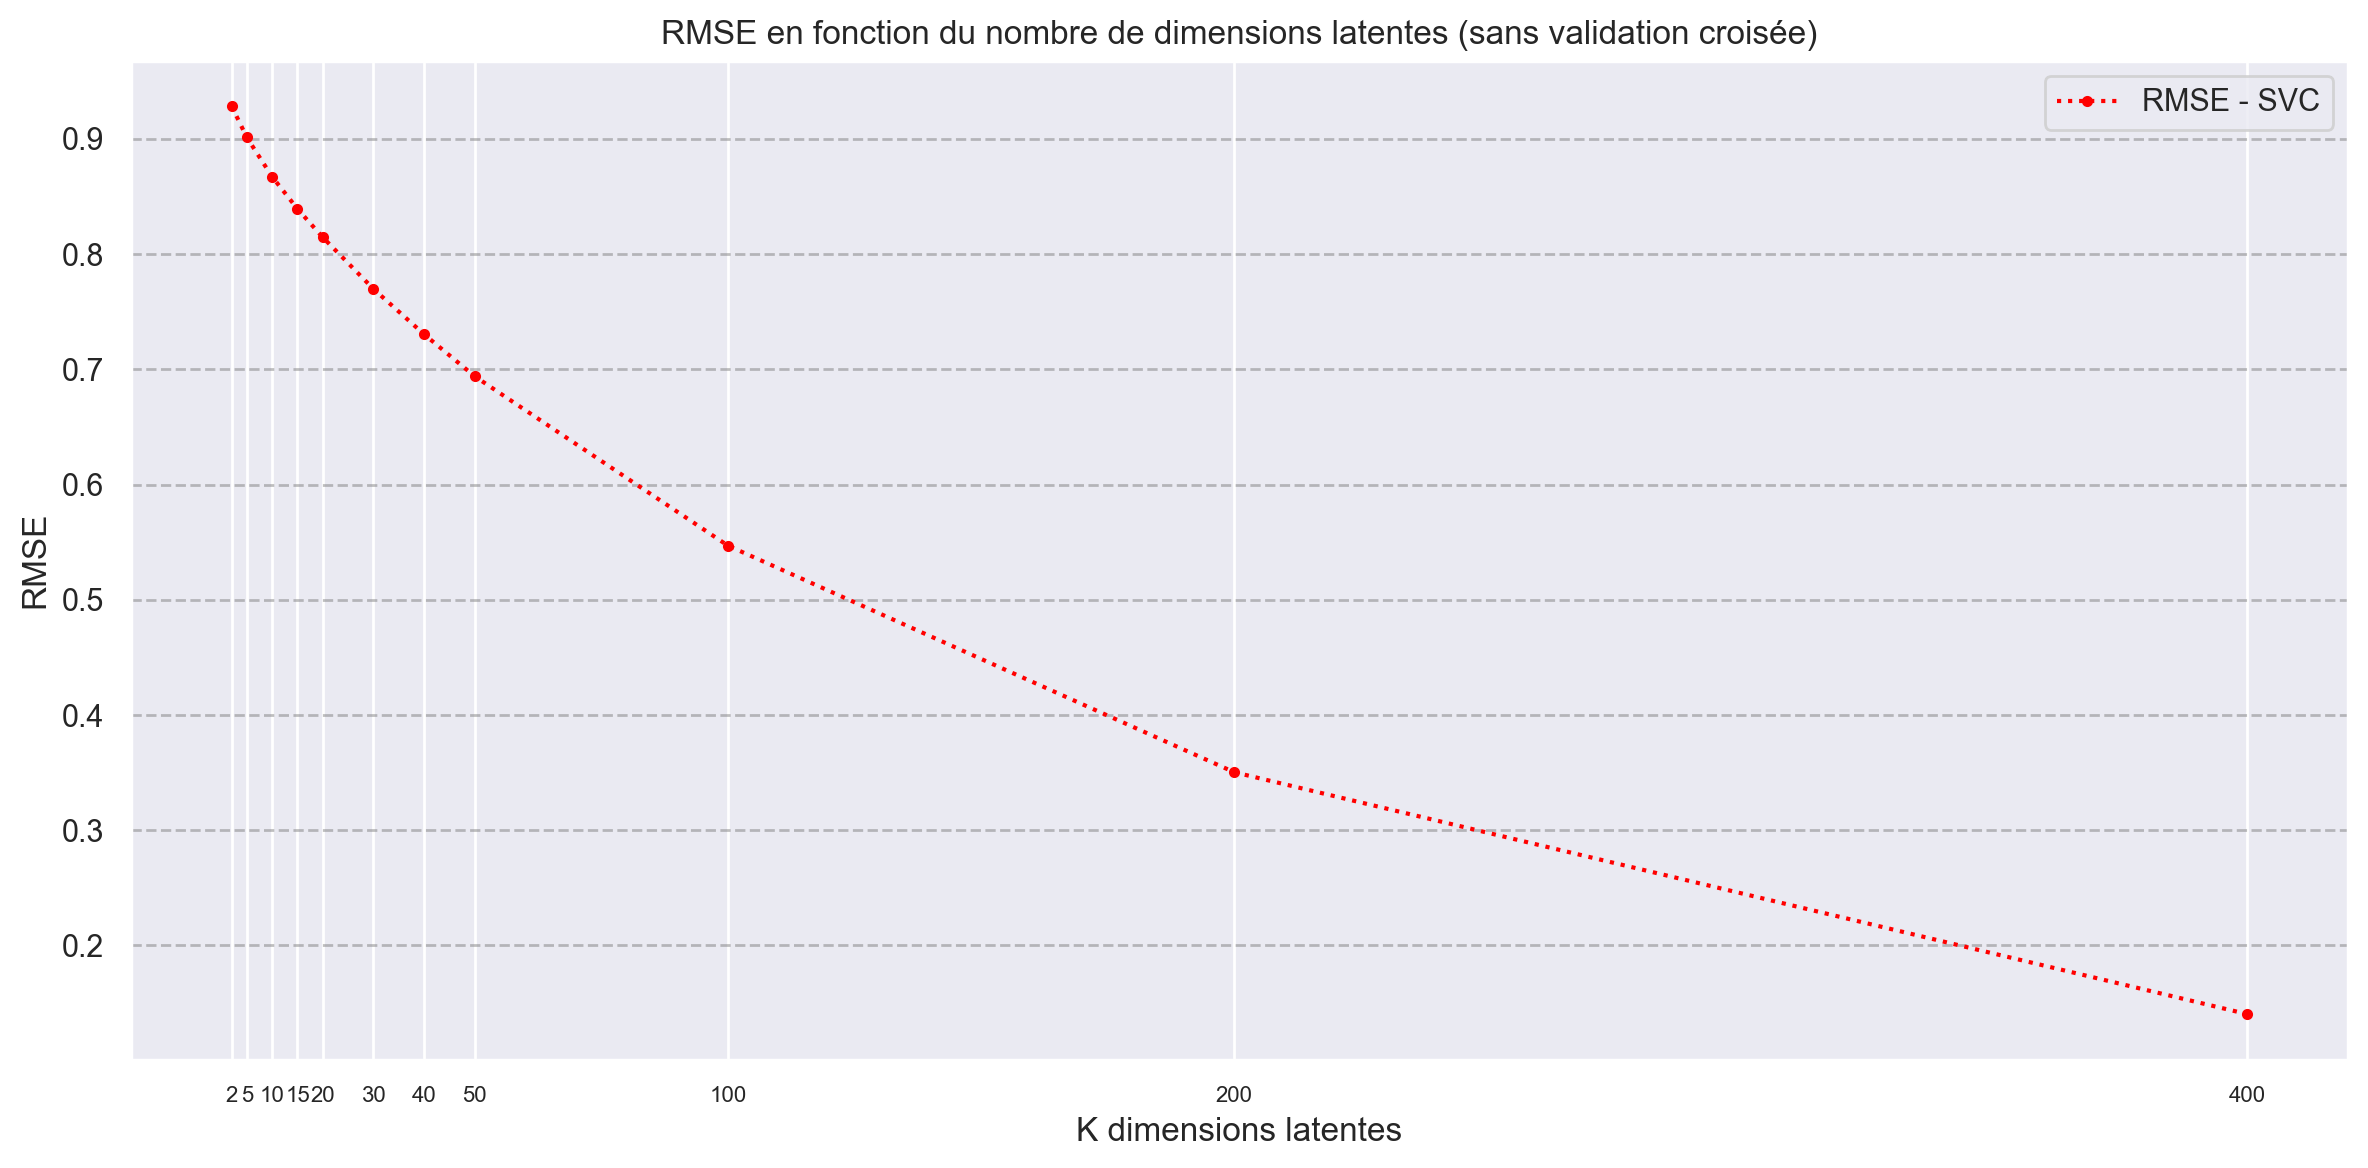

In [14]:
# Afficher la courbe RMSE en fonction du nombre de dimensions.
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
ax.plot(list_k, list_RMSE_svc, marker='.', color='red', linestyle=':', label="RMSE - SVC")
ax.set_ylabel('RMSE')
ax.set_xlabel('K dimensions latentes')
ax.set_title('RMSE en fonction du nombre de dimensions latentes (sans validation croisée)')
ax.set_xticks(list_k)
plt.xticks(fontsize=8)
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

In [15]:
# # Déterminer la meilleure valeur de K
# Valeur minimale de RMSE et valeur de k correspondante (meilleure valeur de k)
min_rmse = min(list_RMSE_svc)
min_k = list_k[list_RMSE_svc.index(min_rmse)]
print('Meilleure valeur de K (sans validation croisée) =', min_k)

Meilleure valeur de K (sans validation croisée) = 400


### Analyse (sans validation croisée)
La valeur minimale du RMSE est atteinte pour k=400, ce qui en fait la meilleure valeur de k. Cela correspond au cas sans validation croisée, car plus le nombre de dimensions utilisées augmente, plus la reconstruction se rapproche de la matrice originale, ce qui réduit l'erreur entre la matrice originale et la matrice prédite. Cependant, cette diminution de l'erreur est due au surajustement, car le modèle capte non seulement la structure sous-jacente des données, mais aussi le bruit présent dans la matrice originale.

**Validation croisée**

Indication: 
- On itère sur les replis avant d'itérer sur le nombre de valeurs singulières $k$ que l'on retient. C'est un détail qui permet d'être plus performant en temps de calcul.
- Un variable contenant les indices a déjà été crée plus haut

In [16]:
%%time
np.random.seed(42)
list_RMSE = []
list_MAE  = []
list_R_pred = []

for i in range(nbre_replis):
    list_RMSE_i = []
    list_MAE_i  = []

    idx_train = np.delete(idx_split, i, axis=0).flatten()
    idx_valid = idx_split[i]

    ## On enlève les valeurs de test de la matrice d'entrainement, et les valeurs de train dans la matrice de test
    MUI_numpy_train = MUI_numpy_flat.copy()
    MUI_numpy_train[idx_valid] = np.nan
    MUI_numpy_valid = MUI_numpy_flat.copy()
    MUI_numpy_valid[idx_train] = np.nan

    ## On redonne la structure de matrice aux ensembles de test et d'entrainement
    R_train = MUI_numpy_train.reshape(MUI_numpy.shape) # Valeurs de train
    MUI_numpy_valid = MUI_numpy_valid.reshape(MUI_numpy.shape) # Valeurs de test
    
    # Centrage de la matrice
    R_biais    = Biais_mat(R_train)
    R_centered = R_train - R_biais
    R_centered[np.isnan(R_centered)] = 0

    # Décomposition SVD de la matrice centrée
    u, sigma, v_trans = SVD_decomp(R_centered)

    # Boucle sur différentes valeurs de k (dimensions latentes)
    for k in list_k:
        # Pred
        R_pred = SVD_matpred(u, sigma, v_trans, k)
        list_R_pred.append(R_pred)

        list_RMSE_i.append(RMSE_mat(R_pred + R_biais, MUI_numpy_valid))
        list_MAE_i.append(MAE_mat(R_pred + R_biais, MUI_numpy_valid))

    list_RMSE.append(np.array(list_RMSE_i))
    list_MAE.append(np.array(list_MAE_i))

list_RMSE = np.array(list_RMSE)
list_MAE  = np.array(list_MAE)

C:\Users\ettah\AppData\Local\Temp\ipykernel_14120\1063885368.py:9: RuntimeWarning: Mean of empty slice
  item_mean = np.nanmean(R, axis=0)


CPU times: total: 55.4 s
Wall time: 9.31 s


In [17]:
# Mean per value of k
list_RMSE_mean = list_RMSE.mean(axis=0)

In [18]:
values_of_k    = [k for i in range(nbre_replis) for k in list_k]
values_of_rmse = list_RMSE.flatten()
df_q1 = pd.DataFrame.from_dict({"Number of Dimensions Taken": values_of_k, "Root Mean Square Error on Validation": values_of_rmse})
df_q1.sort_values("Number of Dimensions Taken").head()

,Number of Dimensions Taken,Root Mean Square Error on Validation
0,2,0.961545
22,2,0.955148
33,2,0.954861
44,2,0.960332
11,2,0.960501


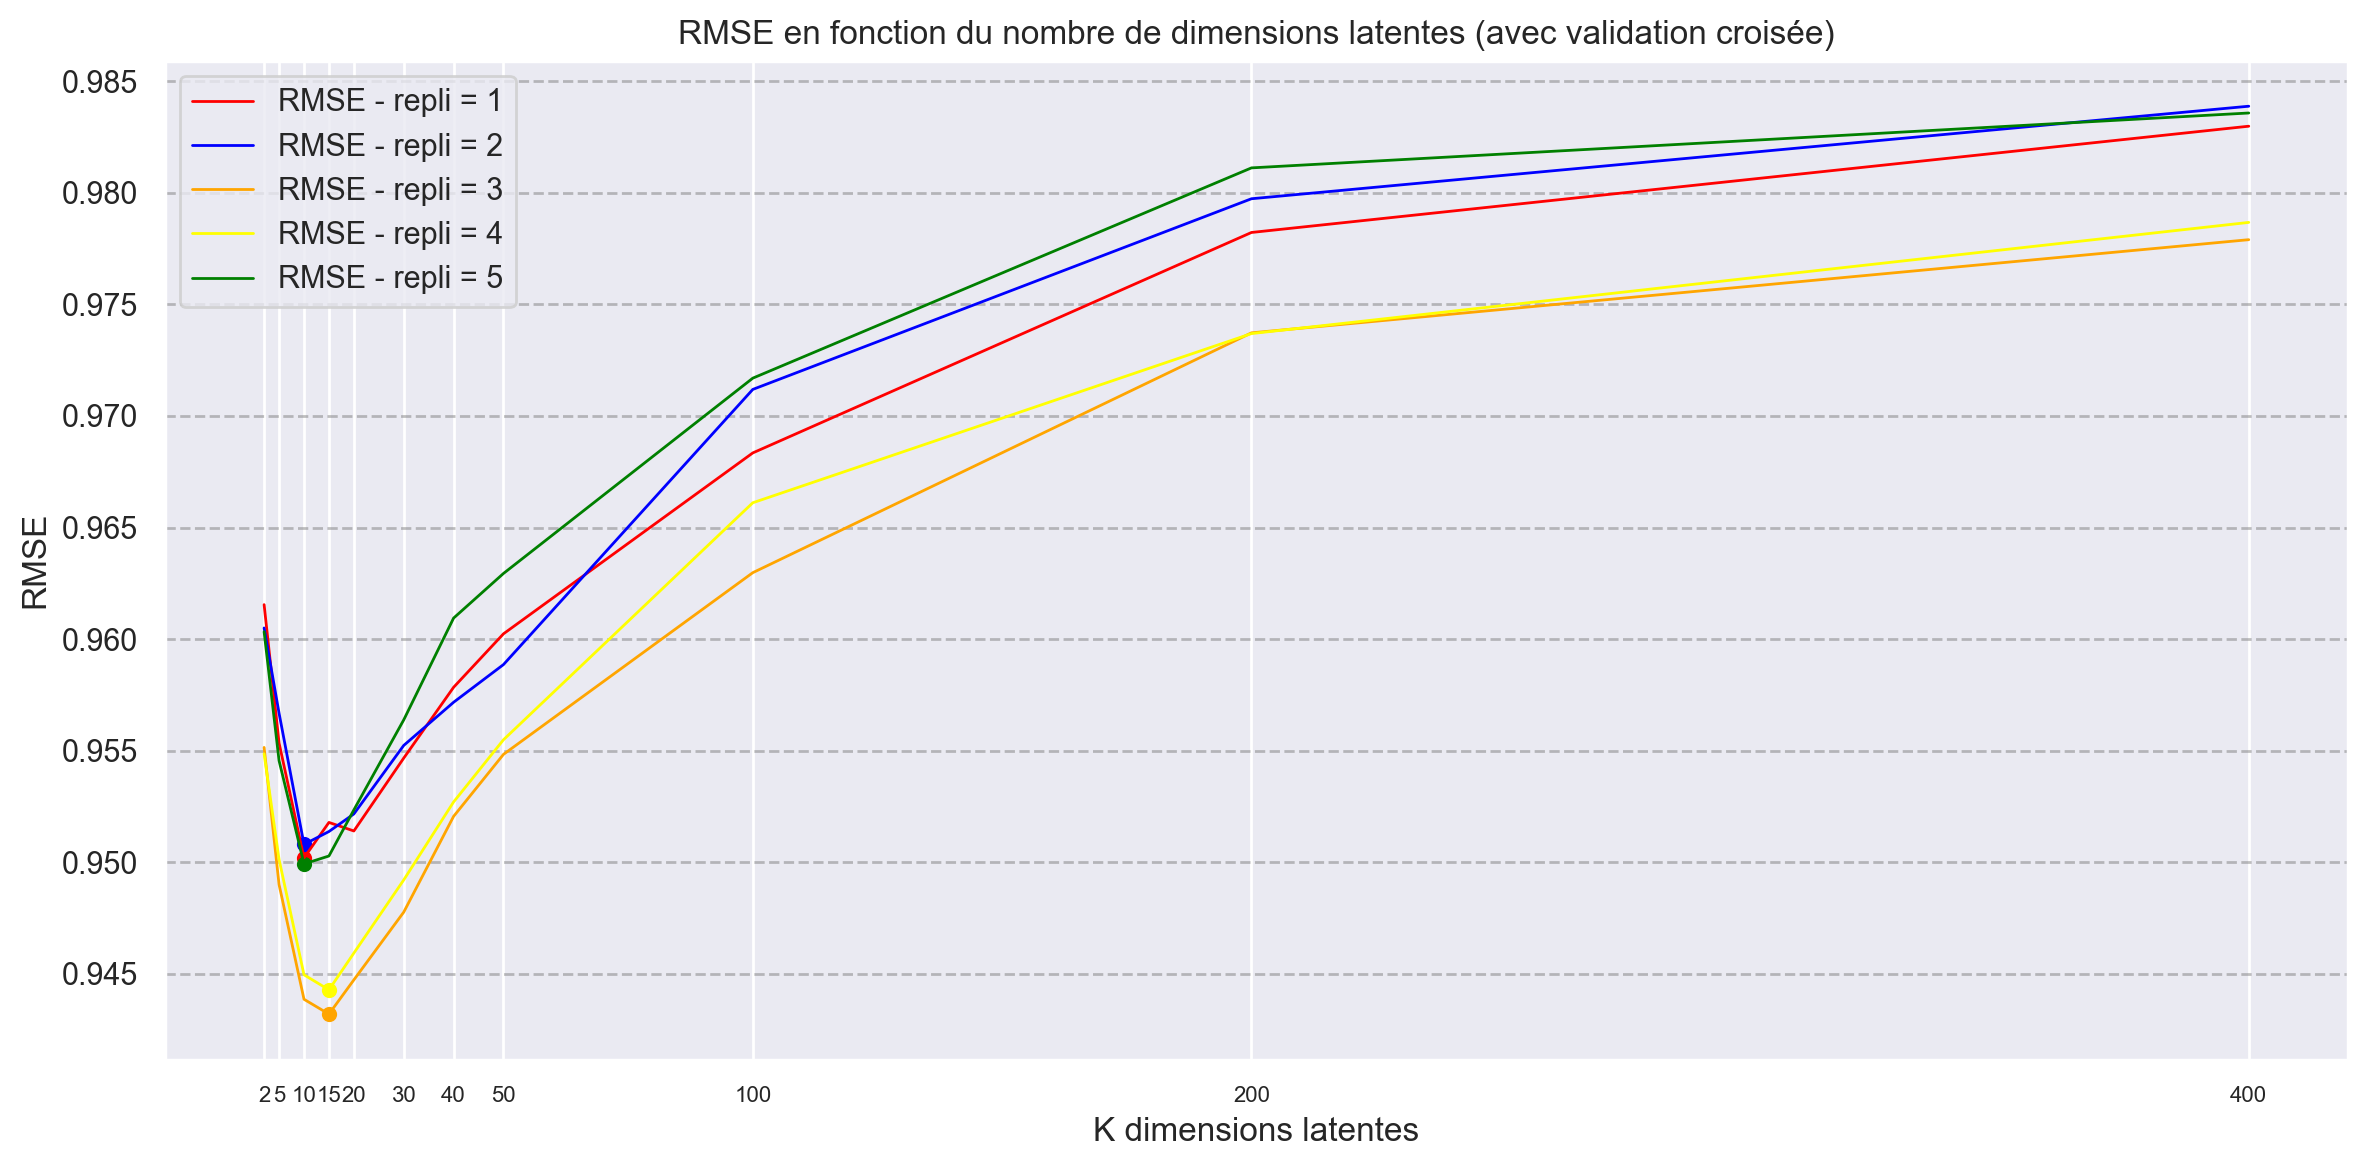

In [19]:
# Afficher les courbes de RMSE en fonction du nombre de dimensions choisies
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

ax.plot(list_k, list_RMSE[0], color='red', linewidth=1, label="RMSE - repli = 1")
ax.plot(list_k, list_RMSE[1], color='blue', linewidth=1, label="RMSE - repli = 2")
ax.plot(list_k, list_RMSE[2], color='orange', linewidth=1, label="RMSE - repli = 3")
ax.plot(list_k, list_RMSE[3], color='yellow', linewidth=1, label="RMSE - repli = 4")
ax.plot(list_k, list_RMSE[4], color='green', linewidth=1, label="RMSE - repli = 5")

plt.scatter(list_k[np.argmin(list_RMSE[0])], list_RMSE[0][np.argmin(list_RMSE[0])], color='red', marker='o', s = 20) 
plt.scatter(list_k[np.argmin(list_RMSE[1])], list_RMSE[1][np.argmin(list_RMSE[1])], color='blue', marker='o', s = 20)
plt.scatter(list_k[np.argmin(list_RMSE[2])], list_RMSE[2][np.argmin(list_RMSE[2])], color='orange', marker='o', s = 20)
plt.scatter(list_k[np.argmin(list_RMSE[3])], list_RMSE[3][np.argmin(list_RMSE[3])], color='yellow', marker='o', s = 20)
plt.scatter(list_k[np.argmin(list_RMSE[4])], list_RMSE[4][np.argmin(list_RMSE[4])], color='green', marker='o', s = 20)

ax.set_ylabel('RMSE')
ax.set_xlabel('K dimensions latentes')
ax.set_title('RMSE en fonction du nombre de dimensions latentes (avec validation croisée)')
ax.set_xticks(list_k)
plt.xticks(fontsize=8)
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

In [20]:
# # Déterminer la meilleure valeur de K et comparé vos resultats avec ceux obtenus dans l'approches sans validation croisée.
# Valeur optimale de k pour chaque réplis
list_k_opt = []
list_RMSE_min = []
for i, list_rmse_i in enumerate(list_RMSE):
    min_rmse_i = np.min(list_rmse_i)
    min_index = np.argmin(list_rmse_i)
    min_k_i = list_k[min_index]
    list_k_opt.append(min_k_i)
    list_RMSE_min.append(min_rmse_i)
    print(f"repli {i+1}, k optimal = {min_k_i}, RMSE = {min_rmse_i:.4f}")
print(f"\nk optimal global = {list_k_opt[np.argmin(list_RMSE_min)]}, RMSE = {list_RMSE_min[np.argmin(list_RMSE_min)]}")

repli 1, k optimal = 10, RMSE = 0.9502
repli 2, k optimal = 10, RMSE = 0.9508
repli 3, k optimal = 15, RMSE = 0.9432
repli 4, k optimal = 15, RMSE = 0.9443
repli 5, k optimal = 10, RMSE = 0.9499

k optimal global = 15, RMSE = 0.9431994752467582


### Analyse
- Sans validation croisée, l’erreur diminue de manière très marquée à mesure que le nombre de dimensions retenues augmente. Elle passe ainsi de 0.92 pour k = 2  à 0.14 pour k = 400, ce qui indique un surajustement. Cela s'explique par le fait que k = 400 permet de reconstruire une matrice très proche aux données originales. Si le nombre de dimensions continue d'augmenter, l'erreur continuerait de diminuer progressivement, atteignant 0 lorsque toutes les dimensions sont utilisées, ce qui correspond à une reconstruction parfaite des données initiales.
- Avec validation croisée, les erreurs restent plus stables pour différentes valeurs k, se situant entre 0.94 et 0.98. Cela montre que les résultats sont plus robustes et représentatifs. Dans ce cas, le choix k = 15 est privilégié, car il permet d’obtenir les meilleurs résultats avec un nombre de dimensions beaucoup plus réduit, évitant ainsi un ajustement excessif aux données.

**Prédiction**

Supposons un nouvel utilisateur qui a visionné le film "Clockwork Orange" (numéro 179, indice 178 si les indices commencent à 0).  Utilisez l'approche SVD de prédiction pour lui recommander 10 films.

In [21]:
# Fonction qui prend en argument un vecteur ou une matrice de votes d'un utilisateur (lignes de la matrice) et retourne les indices des k films les plus similaires
def k_most_similar(votes, k=10):
    
    # Remplacer les NaN par 0 dans le vecteur de votes
    votes[np.isnan(votes)] = 0

    # Trouver la meilleure prédiction (celle avec le RMSE minimal lors de l'entraînement)
    R_centered = list_R_pred[np.argmin(list_RMSE.flatten())]
    
    # Décomposer la matrice centrée en SVD
    u0, sigma0, v_trans0 = SVD_decomp(R_centered)

    # Prédire les scores pour tous les films
    u_hat = votes @ v_trans0.T @ np.linalg.inv(sigma0)
    R_hat = u_hat @ sigma0 @ v_trans0

    # Exclure les films déjà vus (votes non nuls)
    R_hat_unseen = R_hat.copy()
    seen_idx = np.where(votes != 0)[0]
    R_hat_unseen[seen_idx] = 0

    # Trouver les indices des k films les plus similaires (non vus)
    top_k_indices = np.argsort(R_hat_unseen)[-k:][::-1]
    return top_k_indices

In [22]:
items[items[' movie.title'].str.contains('Clockwork Orange', case=False)]

,movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
178,179,"Clockwork Orange, A (1971)",01-Jan-1971,NaN,http://us.imdb.com/M/title-exact?Clockwork%20O...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Scénario 1 : Prédiction avec vote moyen pour "Clockwork Orange"

In [23]:
# Initialiser du vecteur votes
votes = np.full(MUI_numpy.shape[1], np.nan)
votes[178] = np.nanmean(MUI_numpy, axis=0)[178]

# Récupérer les top_10 films recommandés
top_k_indices = k_most_similar(votes, 10)
print("10 films les plus recommandés (vote moyen) :", top_k_indices)

# Afficher les films recommandés
ajusted_ids = [i + 1 for i in top_k_indices]
recommended_movies = items[items['movie.id'].isin(ajusted_ids)].copy()

recommended_movies['movie.id'] = pd.Categorical(recommended_movies['movie.id'], categories=ajusted_ids, ordered=True)
recommended_movies.sort_values('movie.id')

10 films les plus recommandés (vote moyen) : [ 641 1142 1004  619  604  794 1125  598  361 1153]


,movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
641,642,"Grifters, The (1990)",01-Jan-1990,NaN,"http://us.imdb.com/M/title-exact?Grifters,%20T...",0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1142,1143,Hard Eight (1996),28-Feb-1997,NaN,http://us.imdb.com/Title?Hard+Eight+(1996),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1004,1005,"Double vie de Véronique, La (Double Life of Ve...",01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Podwojne%20zy...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
619,620,"Chamber, The (1996)",11-Oct-1996,NaN,"http://us.imdb.com/M/title-exact?Chamber,%20Th...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
604,605,Meet Me in St. Louis (1944),01-Jan-1944,NaN,http://us.imdb.com/M/title-exact?Meet%20Me%20i...,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
794,795,Richie Rich (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Richie%20Rich...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1125,1126,"Old Man and the Sea, The (1958)",01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Old%20Man%20a...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
598,599,Police Story 4: Project S (Chao ji ji hua) (1993),16-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Project%20S%2...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
361,362,Blues Brothers 2000 (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Blues+Brother...,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1153,1154,Alphaville (1965),01-Jan-1965,NaN,http://us.imdb.com/M/title-exact?Alphaville%20...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Scénario 2 : Prédiction avec vote=1 pour "Clockwork Orange"

In [24]:
# Initialiser du vecteur votes
votes = np.full(MUI_numpy.shape[1], np.nan)
votes[178] = 1

# Récupérer les top_10 films recommandés
top_k_indices = k_most_similar(votes, 10)
print("10 films les plus recommandés (vote=1) :", top_k_indices)

# Afficher les films recommandés
ajusted_ids = [i + 1 for i in top_k_indices]
recommended_movies = items[items['movie.id'].isin(ajusted_ids)].copy()

recommended_movies['movie.id'] = pd.Categorical(recommended_movies['movie.id'], categories=ajusted_ids, ordered=True)
recommended_movies.sort_values('movie.id')

10 films les plus recommandés (vote=1) : [ 641 1142 1004  619  604  794 1125  598  361 1153]


,movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
641,642,"Grifters, The (1990)",01-Jan-1990,NaN,"http://us.imdb.com/M/title-exact?Grifters,%20T...",0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1142,1143,Hard Eight (1996),28-Feb-1997,NaN,http://us.imdb.com/Title?Hard+Eight+(1996),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1004,1005,"Double vie de Véronique, La (Double Life of Ve...",01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Podwojne%20zy...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
619,620,"Chamber, The (1996)",11-Oct-1996,NaN,"http://us.imdb.com/M/title-exact?Chamber,%20Th...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
604,605,Meet Me in St. Louis (1944),01-Jan-1944,NaN,http://us.imdb.com/M/title-exact?Meet%20Me%20i...,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
794,795,Richie Rich (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Richie%20Rich...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1125,1126,"Old Man and the Sea, The (1958)",01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Old%20Man%20a...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
598,599,Police Story 4: Project S (Chao ji ji hua) (1993),16-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Project%20S%2...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
361,362,Blues Brothers 2000 (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Blues+Brother...,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1153,1154,Alphaville (1965),01-Jan-1965,NaN,http://us.imdb.com/M/title-exact?Alphaville%20...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [29]:
## Scénario 3 : Prédiction avec vote=4 pour "Clockwork Orange"

In [28]:
# Initialiser du vecteur votes
votes = np.full(MUI_numpy.shape[1], np.nan)
votes[178] = 4

# Récupérer les top_10 films recommandés
top_k_indices = k_most_similar(votes, 10)
print("10 films les plus recommandés (vote=4) :", top_k_indices)

# Afficher les films recommandés
ajusted_ids = [i + 1 for i in top_k_indices]
recommended_movies = items[items['movie.id'].isin(ajusted_ids)].copy()

recommended_movies['movie.id'] = pd.Categorical(recommended_movies['movie.id'], categories=ajusted_ids, ordered=True)
recommended_movies.sort_values('movie.id')

10 films les plus recommandés (vote=4) : [ 641 1142 1004  619  604  794 1125  598  361 1153]


,movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
641,642,"Grifters, The (1990)",01-Jan-1990,NaN,"http://us.imdb.com/M/title-exact?Grifters,%20T...",0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1142,1143,Hard Eight (1996),28-Feb-1997,NaN,http://us.imdb.com/Title?Hard+Eight+(1996),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1004,1005,"Double vie de Véronique, La (Double Life of Ve...",01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Podwojne%20zy...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
619,620,"Chamber, The (1996)",11-Oct-1996,NaN,"http://us.imdb.com/M/title-exact?Chamber,%20Th...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
604,605,Meet Me in St. Louis (1944),01-Jan-1944,NaN,http://us.imdb.com/M/title-exact?Meet%20Me%20i...,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
794,795,Richie Rich (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Richie%20Rich...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1125,1126,"Old Man and the Sea, The (1958)",01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Old%20Man%20a...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
598,599,Police Story 4: Project S (Chao ji ji hua) (1993),16-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Project%20S%2...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
361,362,Blues Brothers 2000 (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Blues+Brother...,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1153,1154,Alphaville (1965),01-Jan-1965,NaN,http://us.imdb.com/M/title-exact?Alphaville%20...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Prédiction avec similarité cosinus (item-item)

In [25]:
# Fonction pour le calcul de la similarité cosinus entre deux matrices A et B
def cosine_similarity(A,B):
    # Matrice colonne des normes de chacuns des vecteurs de A
    col_norm_A = np.linalg.norm(A, axis=-1)[:, None]
    # Matrice ligne des normes de chacuns des vecteurs de B
    col_norm_B = np.expand_dims(np.linalg.norm(B, axis=-1), axis=0)
    cos_sim = np.dot(A, B.T) / np.dot(col_norm_A, col_norm_B)
    return cos_sim

# Calcul de la similarité cosinus entre items
MUI_numpy_T = np.nan_to_num(MUI_numpy).T
i_cos = cosine_similarity(MUI_numpy_T, MUI_numpy_T)
np.fill_diagonal(i_cos, 0)

# Sélection des top_k items similaires
x = 179 - 1
top_k = 10
top_k_indices = np.argsort(i_cos[x, :])[-top_k:][::-1]
print("10 films les plus recommandés (similarité items) :", top_k_indices)

ajusted_ids = [i + 1 for i in top_k_indices]
recommended_movies = items[items['movie.id'].isin(ajusted_ids)].copy()

recommended_movies['movie.id'] = pd.Categorical(recommended_movies['movie.id'], categories=ajusted_ids, ordered=True)
recommended_movies.sort_values('movie.id')

10 films les plus recommandés (similarité items) : [179  22  88 167 134 190 237 173 473 182]


,movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
179,180,Apocalypse Now (1979),01-Jan-1979,NaN,http://us.imdb.com/M/title-exact?Apocalypse%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22,23,Taxi Driver (1976),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Taxi%20Driver...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
88,89,Blade Runner (1982),01-Jan-1982,NaN,http://us.imdb.com/M/title-exact?Blade%20Runne...,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
167,168,Monty Python and the Holy Grail (1974),01-Jan-1974,NaN,http://us.imdb.com/M/title-exact?Monty%20Pytho...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134,135,2001: A Space Odyssey (1968),01-Jan-1968,NaN,http://us.imdb.com/M/title-exact?2001:%20A%20S...,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
190,191,Amadeus (1984),01-Jan-1984,NaN,http://us.imdb.com/M/title-exact?Amadeus%20(1984),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
237,238,Raising Arizona (1987),01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Raising%20Ari...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,174,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
473,474,Dr. Strangelove or: How I Learned to Stop Worr...,01-Jan-1963,NaN,http://us.imdb.com/M/title-exact?Dr.%20Strange...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
182,183,Alien (1979),01-Jan-1979,NaN,http://us.imdb.com/M/title-exact?Alien%20(1979),0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0


### Analyse

Selon l'énoncé, un nouvel utilisateur a visionné le film Clockwork Orange. Nous avons alors testé deux scénarios différents :
* Scénario 1 : Prédiction avec la note moyenne pour Clockwork Orange.
* Scénario 2 : Prédiction avec une note de 1 pour Clockwork Orange.
* Scénario 3 : Prédiction avec une note de 4 pour Clockwork Orange.

Dans ces trois scénarios, les recommandations obtenues sont identiques. De plus, bien que Clockwork Orange soit un film de science-fiction, très peu de films recommandés appartiennent à cette catégorie. Cependant, cette méthode reste pertinente lorsque l'on dispose de très peu d’informations. Elle permet de gérer le problème de démarrage à froid en fournissant des recommandations basées sur des informations minimales.

En revanche, la prédiction basée sur la similarité cosinus (item-item) produit de meilleurs résultats : 4 films sur 10 recommandés appartiennent au genre science-fiction. Toutefois, cette méthode peut nuire à la diversité des recommandations, car elle a tendance à proposer des films très similaires à Clockwork Orange.

## Question 2 (8 points)

L’algorithme K-means est une méthode de regroupement/agglomération (*clustering*) qui divise les utilisateurs (ou items) en plusieurs classes homogènes basées sur leurs similarités. Dans le cadre de ce TP, K-means sert à :

- Identifier des groupes d’utilisateurs ou d’items similaires selon leurs interactions (par exemple, des utilisateurs ayant des préférences proches ou des films avec des profils similaires de spectateurs).
- Simplifier les prédictions en supposant que les membres d’un même groupe auront des comportements similaires (par exemple, des utilisateurs d’un même cluster auront des votes comparables).
- Tester comment le choix du nombre de classes ($k$) influence la précision des prédictions (RMSE) et la capacité du modèle à capturer les relations dans les données.

Cette approche permet d’explorer comment le regroupement peut simplifier la personnalisation des recommandations et servir d’alternative (ou de complément) à d'autres méthodes comme SVD ou les filtres collaboratifs.

**Instructions :**
  
Utilisez une approche par agglomération (clustering) pour prédire les votes et calculez l'erreur quadratique moyenne. Utilisez 2, 5, 10, 20, et 40 classes. Prenez l'approche K-moyenne (K-means) et utilisez la corrélation comme mesure de distance et une validation croisée de 5 replis pour établir quel est le nombre de classes à retenir parmi les 5 mentionnés. Une bonne explication de l'algorithme k-means est fournie par Alexandre Ihler dans cette [vidéo](https://www.youtube.com/watch?v=mfqmoUN-Cuw&feature=youtu.be).

### Distances
Afin d'effectuer la mesure de distance dans l'approches KMEANS, les fonctions suivantes calculent la distance de Pearson et la distance Euclidienne.

#### Distance de Pearson

In [30]:
## Distance de Pearson avec des Nans
def PearsonDist(x, y):
    if(len(x.shape) < len(y.shape)):# For Cluster Assignment
        x = np.expand_dims(x, axis=0).repeat(y.shape[0], axis=0)
        nan_or = np.logical_or(np.isnan(x), np.isnan(y))
        corr   = [pearsonr(x[i, ~nan_or[i]], y[i, ~nan_or[i]])[0] if((~nan_or[i]).sum() >=2) else 1 for i in range(y.shape[0])]
    elif(len(x.shape) > len(y.shape)):
        y = np.expand_dims(y, axis=0).repeat(x.shape[0], axis=0)
        nan_or = np.logical_or(np.isnan(x), np.isnan(y))
        corr   = [pearsonr(x[i, ~nan_or[i]], y[i, ~nan_or[i]])[0] if((~nan_or[i]).sum() >=2) else 1 for i in range(y.shape[0])]
    else:# For training phase
        nan_or = np.logical_or(np.isnan(x), np.isnan(y))
        if((~nan_or).sum() <2):
            return 1
        corr   = pearsonr(x[~nan_or], y[~nan_or])[0]
    return 1 - np.abs(corr)

#### Distance Euclidienne

In [31]:
def EuclidDist(x, y):
    # x, y = np.array(x), np.array(y)
    nan_or = np.logical_or(np.isnan(x), np.isnan(y))
    if((~nan_or).sum() <2):
        return nan_or.shape[0]
    return np.linalg.norm(x[~nan_or] - y[~nan_or])

#### Prédiction avec la distance de Pearson

In [40]:
%%time
np.random.seed(42)

list_RMSE_q2 = []
list_MAE_q2  = []
list_k_q2    = [2, 5, 10, 20, 40]

for i in  tqdm(range(nbre_replis)):
    list_RMSE_i = []
    list_MAE_i  = []

    idx_train = np.delete(idx_split, i, axis=0).flatten()
    idx_valid = idx_split[i]

    # On enlève les valeurs de test de la matrice d'entrainement, et vice versa
    MUI_numpy_flat_train = MUI_numpy_flat.copy()
    MUI_numpy_flat_train[idx_valid] = np.nan
    MUI_numpy_flat_valid = MUI_numpy_flat.copy()
    MUI_numpy_flat_valid[idx_train] = np.nan

    # On redonne la structure de matrice aux ensembles de test et d'entrainement
    MUI_numpy_train = MUI_numpy_flat_train.reshape(MUI_numpy.shape)
    MUI_numpy_valid = MUI_numpy_flat_valid.reshape(MUI_numpy.shape)

    for num_cluster in list_k_q2:
        ## Remplacer les Nans par le vote moyen pour que K-Means converge en utilisant la fonction Biais_mat définie plus haut.
        data                 = MUI_numpy_train.copy()
        data[np.isnan(data)] = Biais_mat(MUI_numpy_train)[np.isnan(data)]

        ## Entrainement du K-Means
        kclusterer = KMeansClusterer(num_cluster, distance=PearsonDist, repeats=1, avoid_empty_clusters=True)
        assigned_clusters = np.array(kclusterer.cluster(data, assign_clusters=True))

        ## Extraction des centroides
        centroids         = np.array([np.nanmean(MUI_numpy_train[assigned_clusters==k], axis=0) for k in range(num_cluster)])

        ## Matrice de prédictions
        assigned_clusters_valid = [kclusterer.classify(d) for d in MUI_numpy_valid]
        R_pred                  = centroids[assigned_clusters_valid]

        list_RMSE_i.append(RMSE_mat(R_pred, MUI_numpy_valid))
        list_MAE_i.append(MAE_mat(R_pred, MUI_numpy_valid))
        
    list_RMSE_q2.append(np.array(list_RMSE_i))
    list_MAE_q2.append(np.array(list_MAE_i))

list_RMSE_q2 = np.array(list_RMSE_q2)
list_MAE_q2  = np.array(list_MAE_q2)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\ettah\AppData\Local\Temp\ipykernel_14120\1063885368.py:9: RuntimeWarning: Mean of empty slice
  item_mean = np.nanmean(R, axis=0)
<timed exec>:34: RuntimeWarning: Mean of empty slice
C:\Users\ettah\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:28:55<00:00, 1067.15s/it]

CPU times: total: 1h 16min 40s
Wall time: 1h 28min 55s


In [41]:
values_of_k_q2    = [k for i in range(nbre_replis) for k in list_k_q2]
values_of_rmse_q2 = list_RMSE_q2.flatten()
df_q2 = pd.DataFrame.from_dict({"Number of Dimensions Taken": values_of_k_q2, "Root Mean Square Error on Validation": values_of_rmse_q2})
df_q2.sort_values("Number of Dimensions Taken").head()

,Number of Dimensions Taken,Root Mean Square Error on Validation
0,2,1.019782
20,2,1.019737
5,2,1.010413
15,2,1.031179
10,2,1.017014


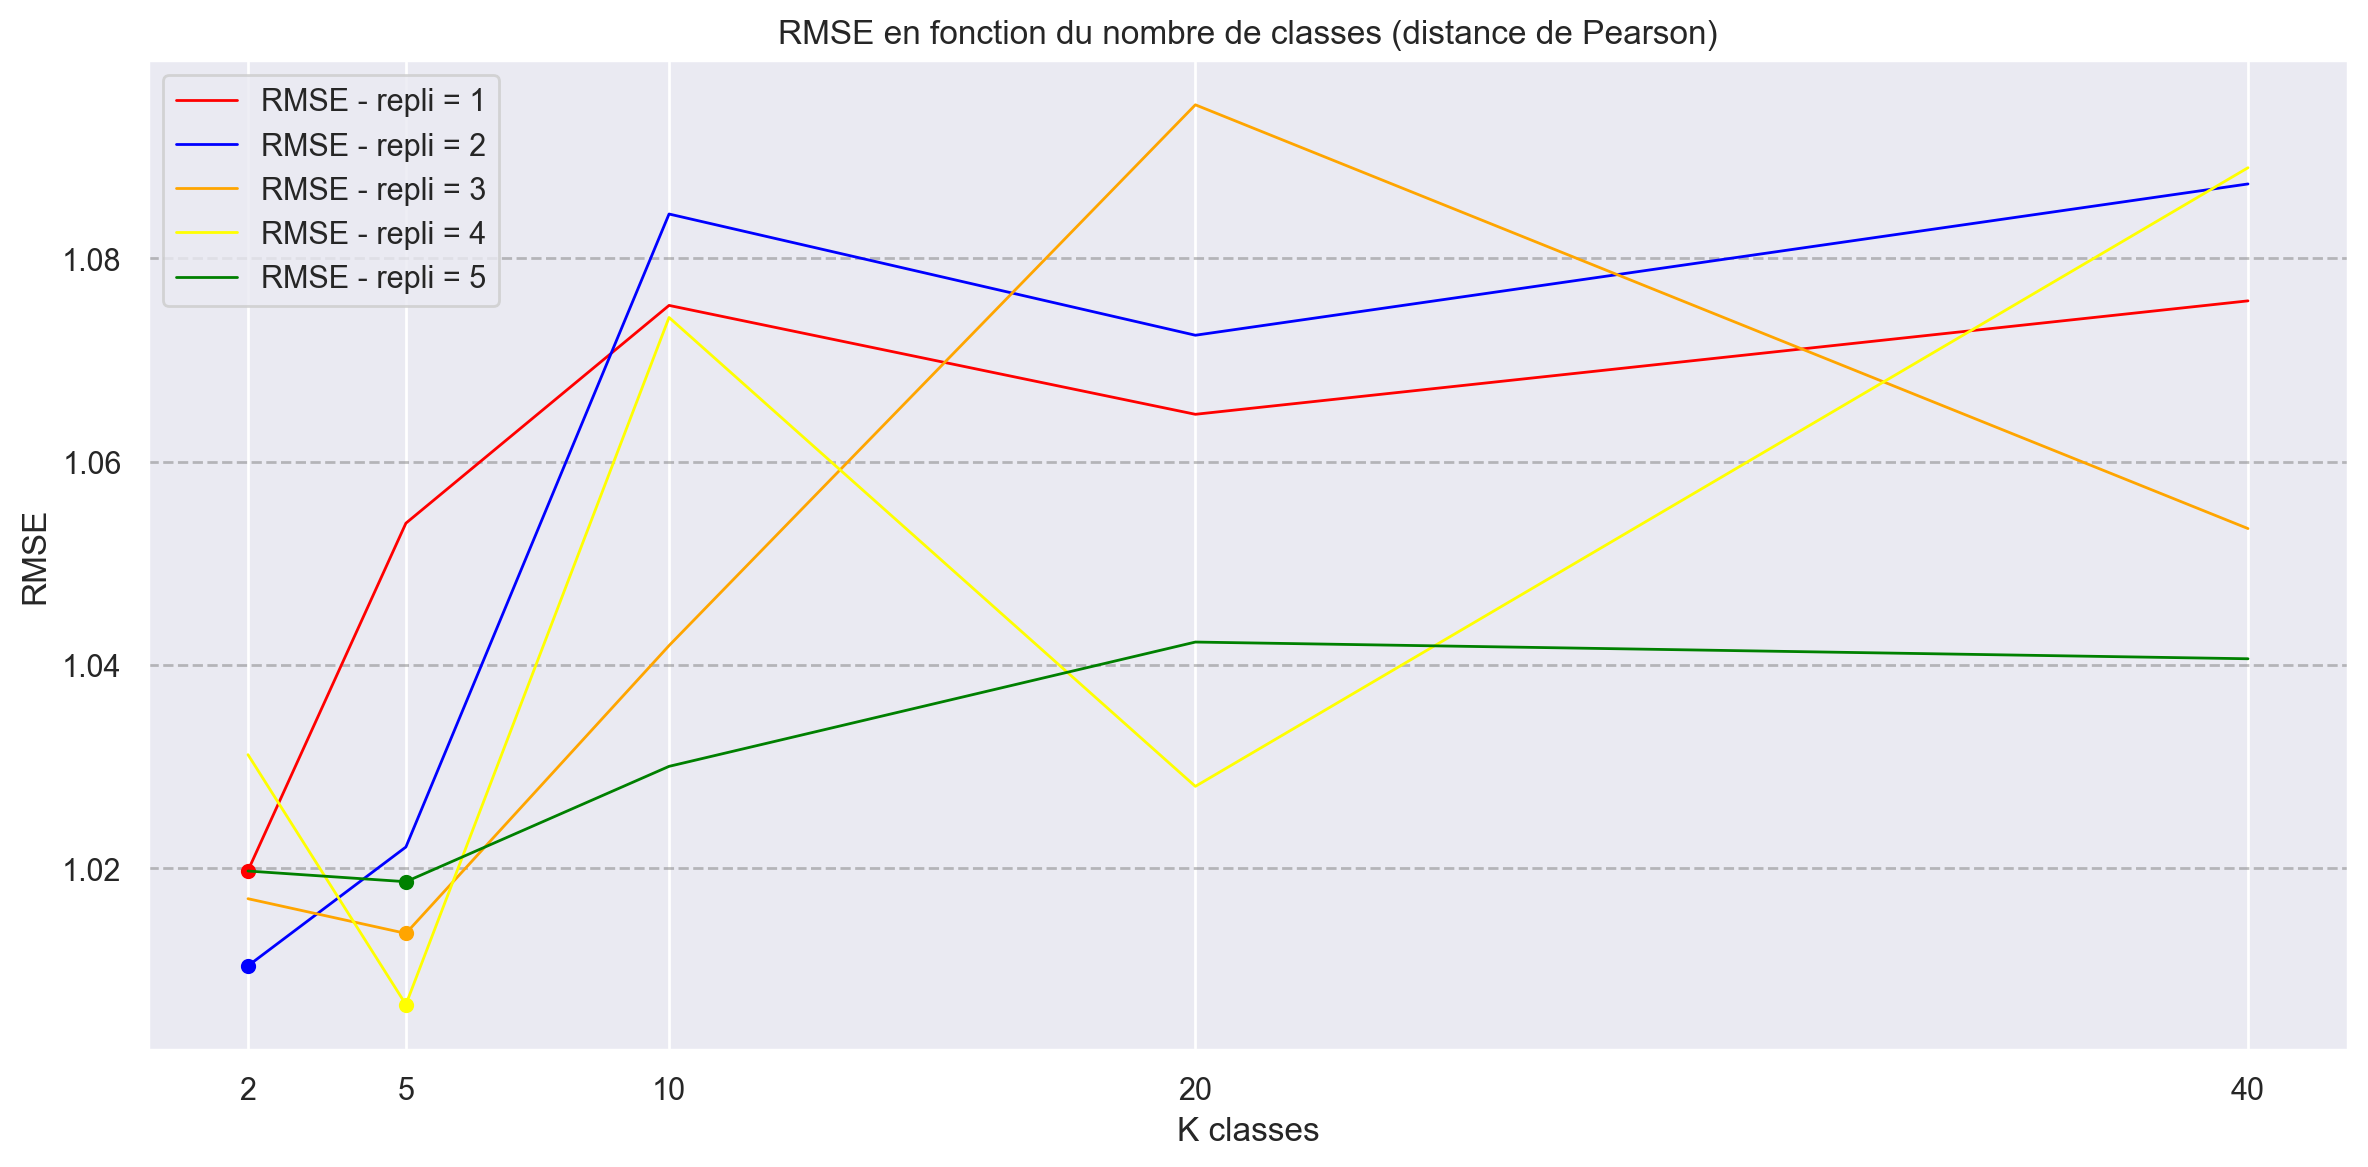

In [42]:
# Afficher les courbes de RMSE en fonction du nombre de dimensions choisies
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

ax.plot(list_k_q2, list_RMSE_q2[0], color='red', linewidth=1, label="RMSE - repli = 1")
ax.plot(list_k_q2, list_RMSE_q2[1], color='blue', linewidth=1, label="RMSE - repli = 2")
ax.plot(list_k_q2, list_RMSE_q2[2], color='orange', linewidth=1, label="RMSE - repli = 3")
ax.plot(list_k_q2, list_RMSE_q2[3], color='yellow', linewidth=1, label="RMSE - repli = 4")
ax.plot(list_k_q2, list_RMSE_q2[4], color='green', linewidth=1, label="RMSE - repli = 5")

plt.scatter(list_k_q2[np.argmin(list_RMSE_q2[0])], list_RMSE_q2[0][np.argmin(list_RMSE_q2[0])], color='red', marker='o', s = 20)
plt.scatter(list_k_q2[np.argmin(list_RMSE_q2[1])], list_RMSE_q2[1][np.argmin(list_RMSE_q2[1])], color='blue', marker='o', s = 20)
plt.scatter(list_k_q2[np.argmin(list_RMSE_q2[2])], list_RMSE_q2[2][np.argmin(list_RMSE_q2[2])], color='orange', marker='o', s = 20)
plt.scatter(list_k_q2[np.argmin(list_RMSE_q2[3])], list_RMSE_q2[3][np.argmin(list_RMSE_q2[3])], color='yellow', marker='o', s = 20)
plt.scatter(list_k_q2[np.argmin(list_RMSE_q2[4])], list_RMSE_q2[4][np.argmin(list_RMSE_q2[4])], color='green', marker='o', s = 20)

ax.set_ylabel('RMSE')
ax.set_xlabel('K classes')
ax.set_title('RMSE en fonction du nombre de classes (distance de Pearson)')
ax.set_xticks(list_k_q2)
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.5)
ax.legend()
plt.tight_layout()

plt.show()

In [43]:
# Déterminer la meilleure valeur de K 
list_k_opt = []
list_RMSE_min = []

for i, list_rmse_i in enumerate(list_RMSE_q2):
    min_rmse_i = np.min(list_rmse_i)
    min_index = np.argmin(list_rmse_i)
    min_k_i = list_k_q2[min_index]
    list_k_opt.append(min_k_i)
    list_RMSE_min.append(min_rmse_i)
    print(f"repli {i+1}, k optimal = {min_k_i}, RMSE = {min_rmse_i:.4f}")

print(f"\nk optimal global = {list_k_opt[np.argmin(list_RMSE_min)]}, RMSE = {list_RMSE_min[np.argmin(list_RMSE_min)]}")

repli 1, k optimal = 2, RMSE = 1.0198
repli 2, k optimal = 2, RMSE = 1.0104
repli 3, k optimal = 5, RMSE = 1.0136
repli 4, k optimal = 5, RMSE = 1.0066
repli 5, k optimal = 5, RMSE = 1.0187

k optimal global = 5, RMSE = 1.0066076540886995


#### Prédiction avec la distance Euclidienne

In [32]:
%%time
np.random.seed(42)

list_RMSE_q2 = []
list_MAE_q2  = []
list_k_q2    = [2, 5, 10, 20, 40]

for i in  tqdm(range(nbre_replis)):
    list_RMSE_i = []
    list_MAE_i  = []

    idx_train = np.delete(idx_split, i, axis=0).flatten()
    idx_valid = idx_split[i]

    # On enlève les valeurs de test de la matrice d'entrainement, et vice versa
    MUI_numpy_flat_train = MUI_numpy_flat.copy()
    MUI_numpy_flat_train[idx_valid] = np.nan
    MUI_numpy_flat_valid = MUI_numpy_flat.copy()
    MUI_numpy_flat_valid[idx_train] = np.nan

    # On redonne la structure de matrice aux ensembles de test et d'entrainement
    MUI_numpy_train = MUI_numpy_flat_train.reshape(MUI_numpy.shape)
    MUI_numpy_valid = MUI_numpy_flat_valid.reshape(MUI_numpy.shape)

    for num_cluster in list_k_q2:
        ## Remplacer les Nans par le vote moyen pour que K-Means converge en utilisant la fonction Biais_mat définie plus haut.
        data                 = MUI_numpy_train.copy()
        data[np.isnan(data)] = Biais_mat(MUI_numpy_train)[np.isnan(data)]

        ## Entrainement du K-Means
        kclusterer = KMeansClusterer(num_cluster, distance=EuclidDist, repeats=1, avoid_empty_clusters=True)
        assigned_clusters = np.array(kclusterer.cluster(data, assign_clusters=True))

        ## Extraction des centroides
        centroids         = np.array([np.nanmean(MUI_numpy_train[assigned_clusters==k], axis=0) for k in range(num_cluster)])

        ## Matrice de prédictions
        assigned_clusters_valid = [kclusterer.classify(d) for d in MUI_numpy_valid]
        R_pred                  = centroids[assigned_clusters_valid]

        list_RMSE_i.append(RMSE_mat(R_pred, MUI_numpy_valid))
        list_MAE_i.append(MAE_mat(R_pred, MUI_numpy_valid))
        
    list_RMSE_q2.append(np.array(list_RMSE_i))
    list_MAE_q2.append(np.array(list_MAE_i))

list_RMSE_q2 = np.array(list_RMSE_q2)
list_MAE_q2  = np.array(list_MAE_q2)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\ettah\AppData\Local\Temp\ipykernel_14120\1063885368.py:9: RuntimeWarning: Mean of empty slice
  item_mean = np.nanmean(R, axis=0)
<timed exec>:34: RuntimeWarning: Mean of empty slice
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:17<00:00, 51.49s/it]

CPU times: total: 2min 45s
Wall time: 4min 17s


In [33]:
values_of_k_q2    = [k for i in range(nbre_replis) for k in list_k_q2]
values_of_rmse_q2 = list_RMSE_q2.flatten()
df_q2 = pd.DataFrame.from_dict({"Number of Dimensions Taken": values_of_k_q2, "Root Mean Square Error on Validation": values_of_rmse_q2})
df_q2.sort_values("Number of Dimensions Taken").head()

,Number of Dimensions Taken,Root Mean Square Error on Validation
0,2,0.975290
20,2,0.979513
5,2,0.983050
15,2,0.972431
10,2,0.971394


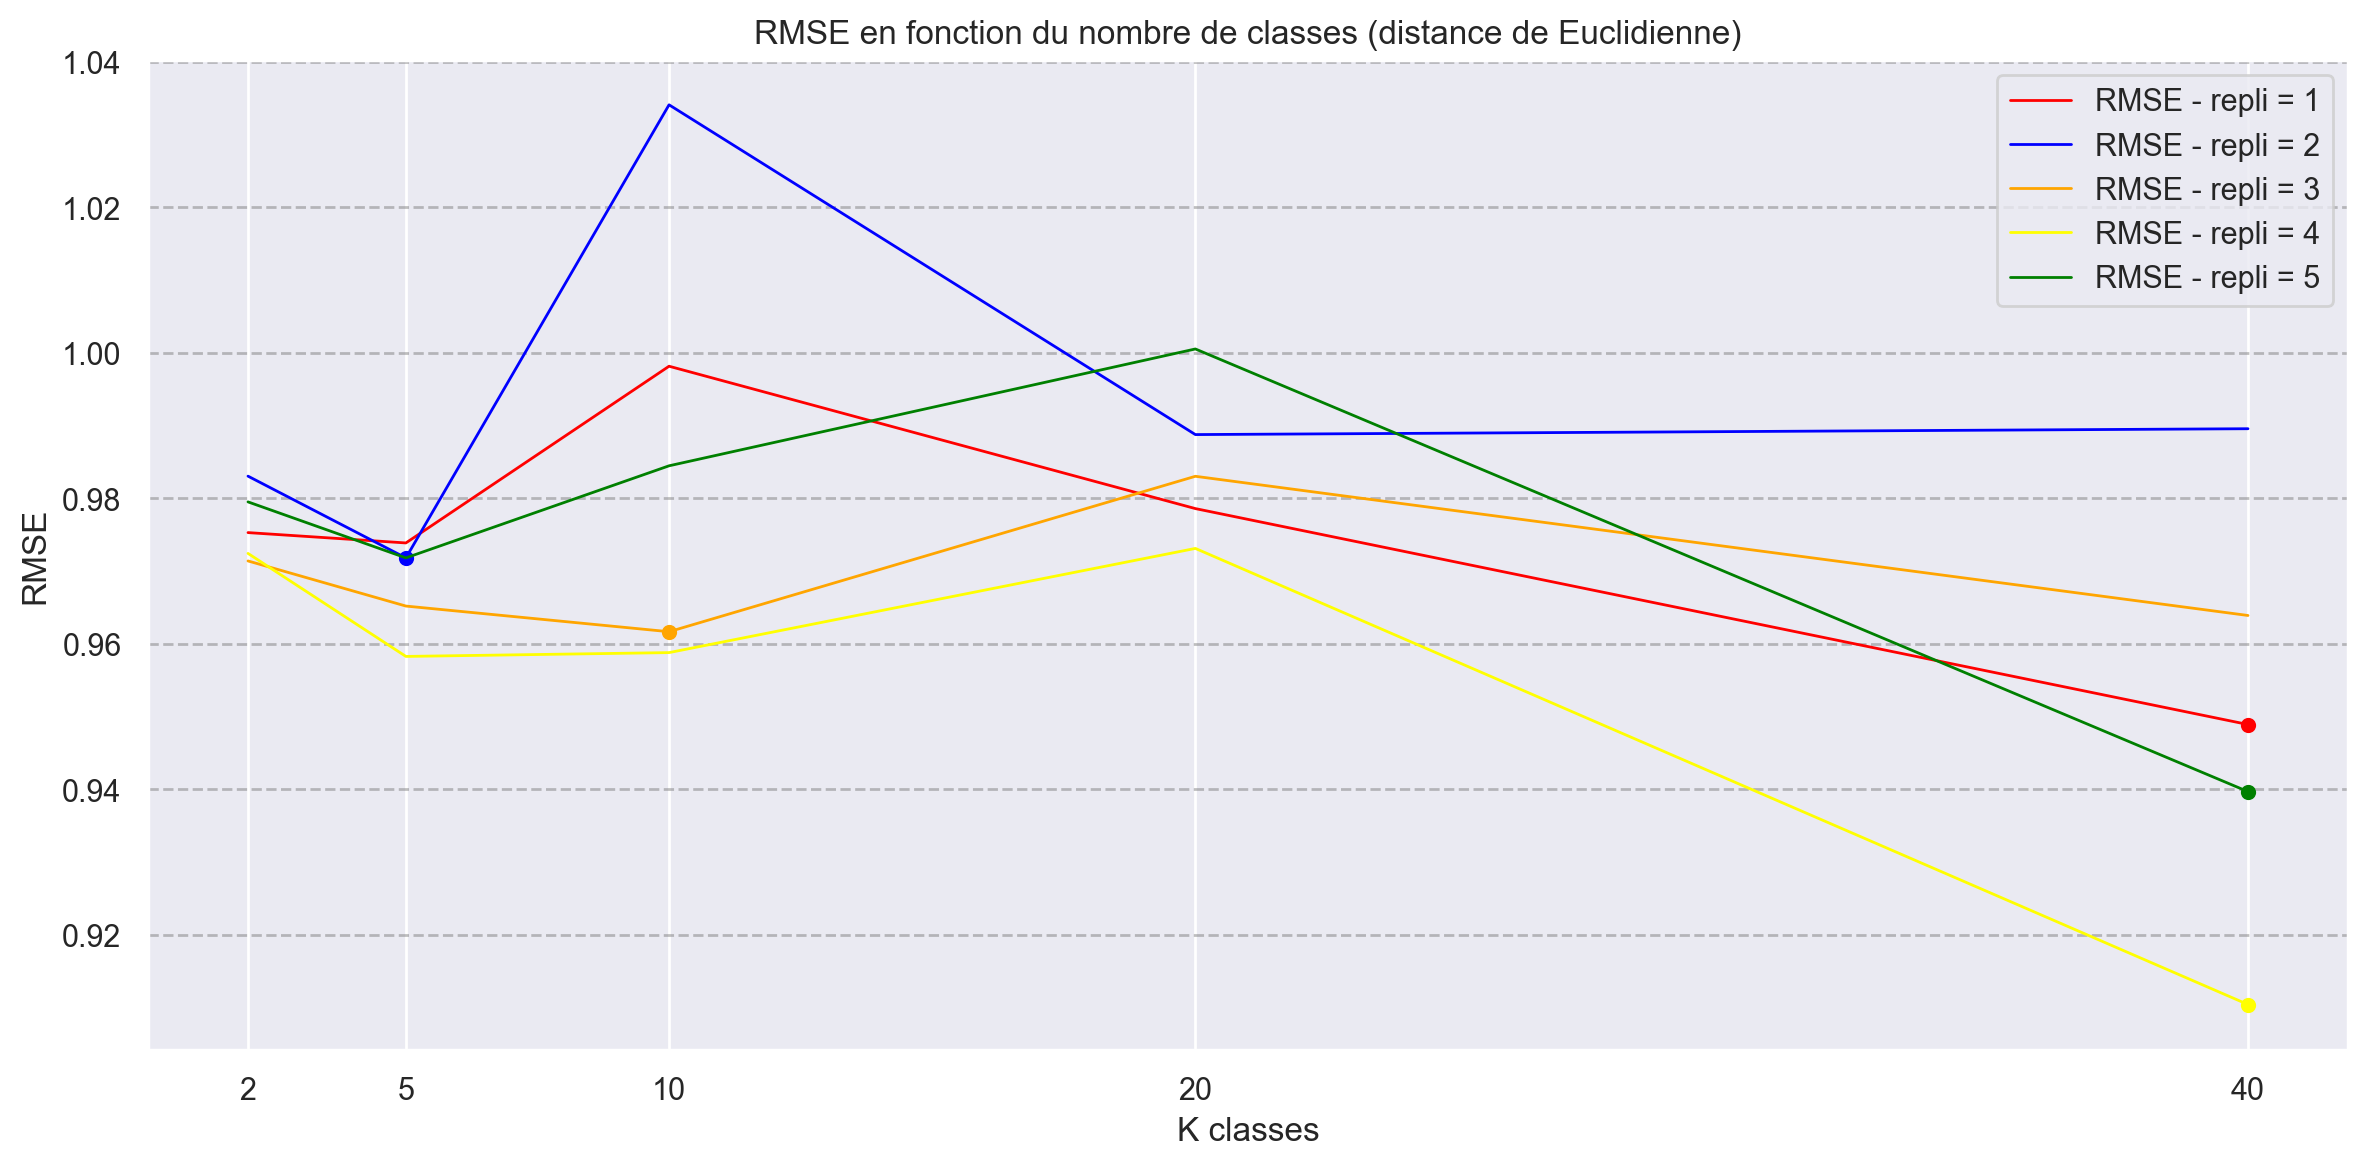

In [37]:
# Afficher les courbes de RMSE en fonction du nombre de dimensions choisies
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

ax.plot(list_k_q2, list_RMSE_q2[0], color='red', linewidth=1, label="RMSE - repli = 1")
ax.plot(list_k_q2, list_RMSE_q2[1], color='blue', linewidth=1, label="RMSE - repli = 2")
ax.plot(list_k_q2, list_RMSE_q2[2], color='orange', linewidth=1, label="RMSE - repli = 3")
ax.plot(list_k_q2, list_RMSE_q2[3], color='yellow', linewidth=1, label="RMSE - repli = 4")
ax.plot(list_k_q2, list_RMSE_q2[4], color='green', linewidth=1, label="RMSE - repli = 5")

plt.scatter(list_k_q2[np.argmin(list_RMSE_q2[0])], list_RMSE_q2[0][np.argmin(list_RMSE_q2[0])], color='red', marker='o', s = 20)
plt.scatter(list_k_q2[np.argmin(list_RMSE_q2[1])], list_RMSE_q2[1][np.argmin(list_RMSE_q2[1])], color='blue', marker='o', s = 20)
plt.scatter(list_k_q2[np.argmin(list_RMSE_q2[2])], list_RMSE_q2[2][np.argmin(list_RMSE_q2[2])], color='orange', marker='o', s = 20)
plt.scatter(list_k_q2[np.argmin(list_RMSE_q2[3])], list_RMSE_q2[3][np.argmin(list_RMSE_q2[3])], color='yellow', marker='o', s = 20)
plt.scatter(list_k_q2[np.argmin(list_RMSE_q2[4])], list_RMSE_q2[4][np.argmin(list_RMSE_q2[4])], color='green', marker='o', s = 20)

ax.set_ylabel('RMSE')
ax.set_xlabel('K classes')
ax.set_title('RMSE en fonction du nombre de classes (distance de Euclidienne)')
ax.set_xticks(list_k_q2)
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

In [39]:
# Déterminer la meilleure valeur de K 
list_k_opt = []
list_RMSE_min = []

for i, list_rmse_i in enumerate(list_RMSE_q2):
    min_rmse_i = np.min(list_rmse_i)
    min_index = np.argmin(list_rmse_i)
    min_k_i = list_k_q2[min_index]
    list_k_opt.append(min_k_i)
    list_RMSE_min.append(min_rmse_i)
    print(f"repli {i+1}, k optimal = {min_k_i}, RMSE = {min_rmse_i:.4f}")

print(f"\nk optimal global = {list_k_opt[np.argmin(list_RMSE_min)]}, RMSE = {list_RMSE_min[np.argmin(list_RMSE_min)]}")

repli 1, k optimal = 40, RMSE = 0.9489
repli 2, k optimal = 5, RMSE = 0.9718
repli 3, k optimal = 10, RMSE = 0.9617
repli 4, k optimal = 40, RMSE = 0.9104
repli 5, k optimal = 40, RMSE = 0.9397

k optimal global = 40, RMSE = 0.9104256966722087


## Conclusion

Après validation croisée avec K-Means (en utilisant la corrélation de Pearson), les performances du modèle restent stables, avec des erreurs variant entre 1.00 et 1.09 selon les valeurs de K. Pour les valeurs optimales de K (sur 5 réplicas), l'erreur est contenue entre 1.00 et 1.01, indiquant une bonne généralisation du modèle.

En comparant les différentes mesures de distance, la corrélation de Pearson conduit à un K optimal plus bas (K = 5), ce qui suggère qu’elle regroupe les utilisateurs en fonction de dynamiques similaires, indépendamment des valeurs absolues de leurs votes. Cela reflète une tendance à capturer des relations linéaires entre les préférences des utilisateurs. À l’inverse, la distance euclidienne optimise le modèle pour K = 40, indiquant une segmentation plus fine, où les groupes sont formés sur la base des écarts absolus entre les votes.

Le choix de la mesure de similarité influence donc fortement les résultats. La corrélation de Pearson est plus adaptée à l’analyse des relations entre utilisateurs partageant des tendances communes, tandis que la distance euclidienne convient mieux aux situations où une segmentation plus granulaire est nécessaire pour capturer les variations absolues des votes.

### Comparaison des résultats

* Avec validation croisée, les erreurs pour l'approche SVD se situant entre 0.94 et 0.98 alors que pour l'approche KMeans avec la corrélation de Pearson, les erreurs dépassent 1 pour tous les réplis. On peut conclure que KMeans produit une dégradation de performance mais ça reste quand même meilleure que la performance obtenue par des votes aléatoires.
* En comparant avec les résultats du TP1, on constate que l'utilisation des voisins rapprochés, combinée à la correction des biais, permet d'obtenir des recommandations plus précises.